### A look into Hotel Reservations dataset

In [116]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import random

sns.set(rc={"figure.dpi":300, 'savefig.dpi':300, 'figure.figsize':(6, 4)})
sns.set_context('notebook', font_scale=0.75)
sns.set_style("darkgrid")
sns.set

random.seed(997)
df = pd.read_csv('hotel-reservations.csv')
print(df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 36275 entries, 0 to 36274
Data columns (total 19 columns):
 #   Column                                Non-Null Count  Dtype  
---  ------                                --------------  -----  
 0   Booking_ID                            36275 non-null  object 
 1   no_of_adults                          36275 non-null  int64  
 2   no_of_children                        36275 non-null  int64  
 3   no_of_weekend_nights                  36275 non-null  int64  
 4   no_of_week_nights                     36275 non-null  int64  
 5   type_of_meal_plan                     36275 non-null  object 
 6   required_car_parking_space            36275 non-null  int64  
 7   room_type_reserved                    36275 non-null  object 
 8   lead_time                             36275 non-null  int64  
 9   arrival_year                          36275 non-null  int64  
 10  arrival_month                         36275 non-null  int64  
 11  arrival_date   

We can see that there are no missing values. 

In [117]:
print(df)

      Booking_ID  no_of_adults  no_of_children  no_of_weekend_nights  \
0       INN00001             2               0                     1   
1       INN00002             2               0                     2   
2       INN00003             1               0                     2   
3       INN00004             2               0                     0   
4       INN00005             2               0                     1   
...          ...           ...             ...                   ...   
36270   INN36271             3               0                     2   
36271   INN36272             2               0                     1   
36272   INN36273             2               0                     2   
36273   INN36274             2               0                     0   
36274   INN36275             2               0                     1   

       no_of_week_nights type_of_meal_plan  required_car_parking_space  \
0                      2       Meal Plan 1                   

Now let's transform 'booking_status' column so it contains boolean values. \
1 - not canceled\
0 - canceled


In [118]:
for index, row in df.iterrows():
    if row['booking_status']=='Canceled':
        df.at[index, 'booking_status'] = 0
    else:
        df.at[index, 'booking_status'] = 1

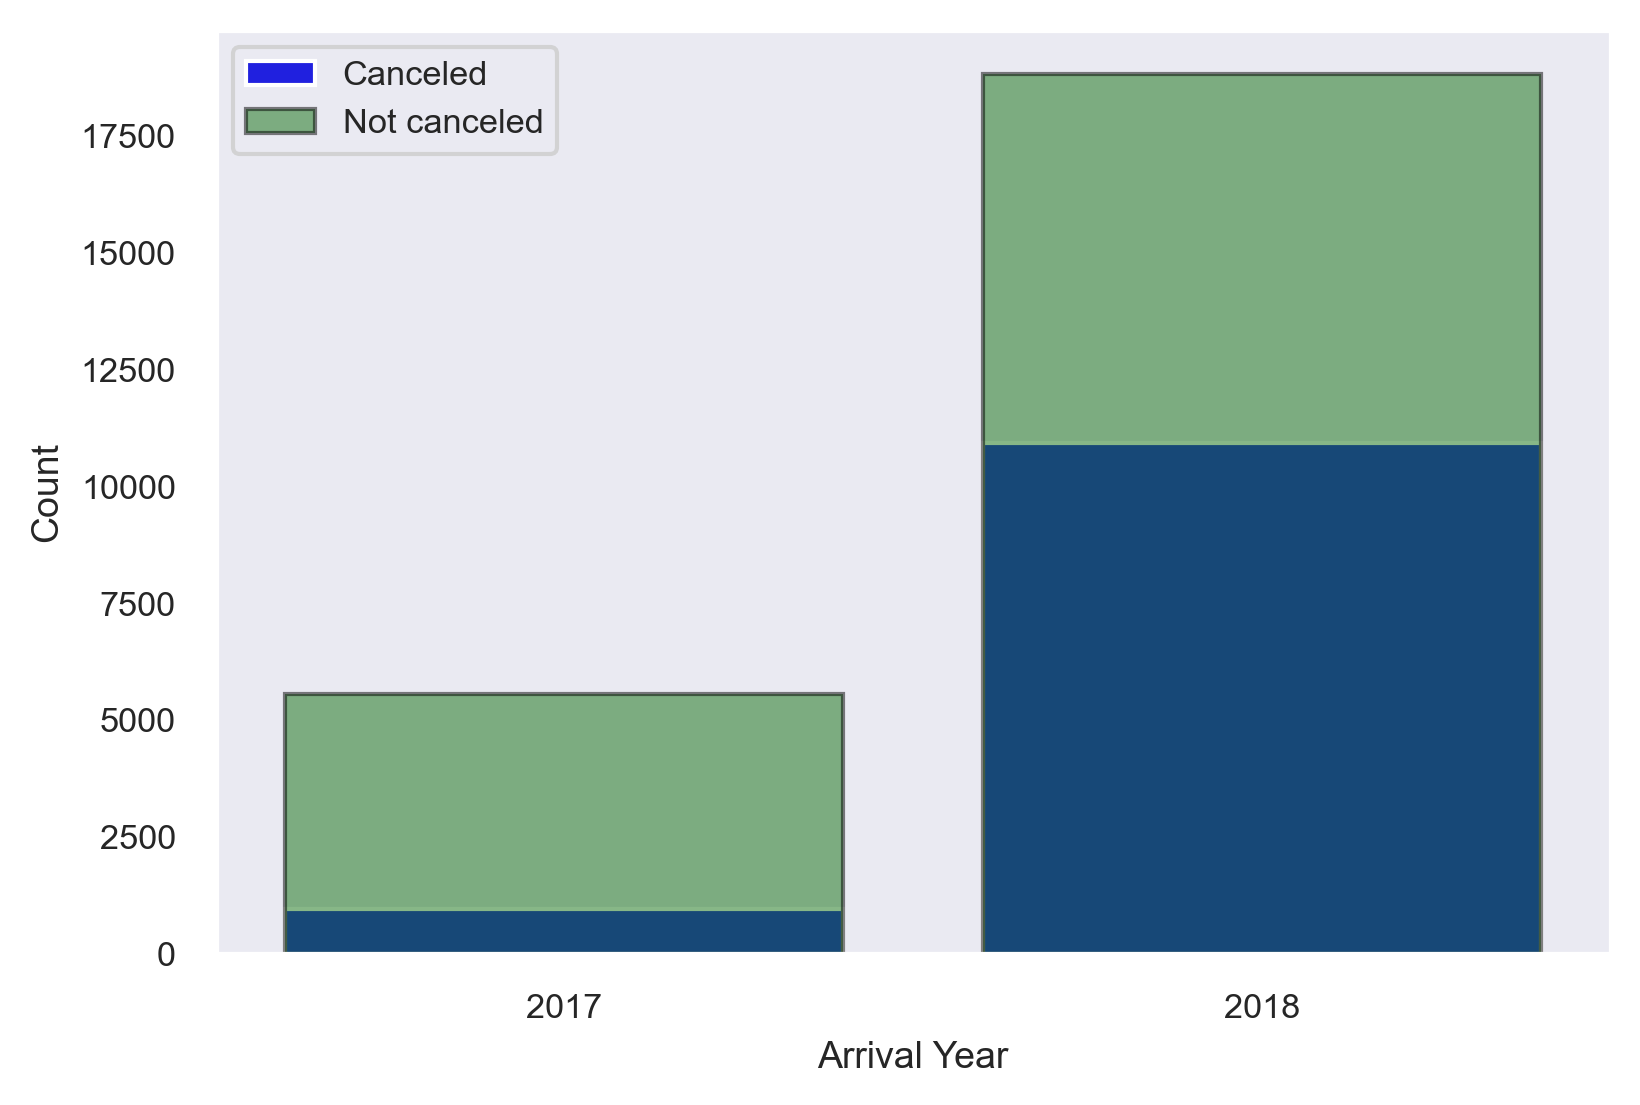

In [119]:
sns.set_style('dark')
pivot_table1 = pd.pivot_table(data=df[df['booking_status']==1], values='booking_status', index='arrival_year', aggfunc='sum')
pivot_table0 = pd.pivot_table(data=df[df['booking_status']==0], values='booking_status', index='arrival_year', aggfunc='count')
pivot_table1.reset_index()
pivot_table0.reset_index()
sns.barplot(data=pivot_table0, x='arrival_year', y='booking_status', color='blue', label='Canceled')
sns.barplot(data=pivot_table1, x='arrival_year', y='booking_status', color='green', label='Not canceled', alpha=0.5, edgecolor='black')
plt.xlabel('Arrival Year')
plt.ylabel('Count')
plt.legend()
plt.show()


Small amount of reservations was canceled in 2017. Over a half of reservations was canceled in 2018
Let's fix the data in columns that contain objects.


In [120]:
for index, row in df.iterrows():
    df.at[index, 'room_type_reserved'] = df.at[index, 'room_type_reserved'][-1]
    # Let's set all Unselected ones to NaN for now
    if type(df.at[index, 'type_of_meal_plan'])!=float:
        df.at[index, 'type_of_meal_plan'] = df.at[index, 'type_of_meal_plan'][-1]
        if df.at[index, 'type_of_meal_plan'] == 'd':
            df.at[index, 'type_of_meal_plan'] = np.nan
   
print(f"Room types: {df['room_type_reserved'].unique()}")
print(f"Meal plans: {df['type_of_meal_plan'].unique()}")
print(df['type_of_meal_plan'].value_counts())

Room types: ['1' '4' '2' '6' '5' '7' '3']
Meal plans: ['1' nan '2' '3']
type_of_meal_plan
1    27835
2     3305
3        5
Name: count, dtype: int64


Replace NaN's with most probable values

In [121]:

non_nans = df['type_of_meal_plan'].dropna().values
test = df['type_of_meal_plan'].isna()
df.loc[test, 'type_of_meal_plan'] = np.random.choice(non_nans, size=test.sum())
print(df['type_of_meal_plan'].value_counts())

type_of_meal_plan
1    32470
2     3797
3        8
Name: count, dtype: int64


Trying to get a grasp of relations between the data

<Axes: >

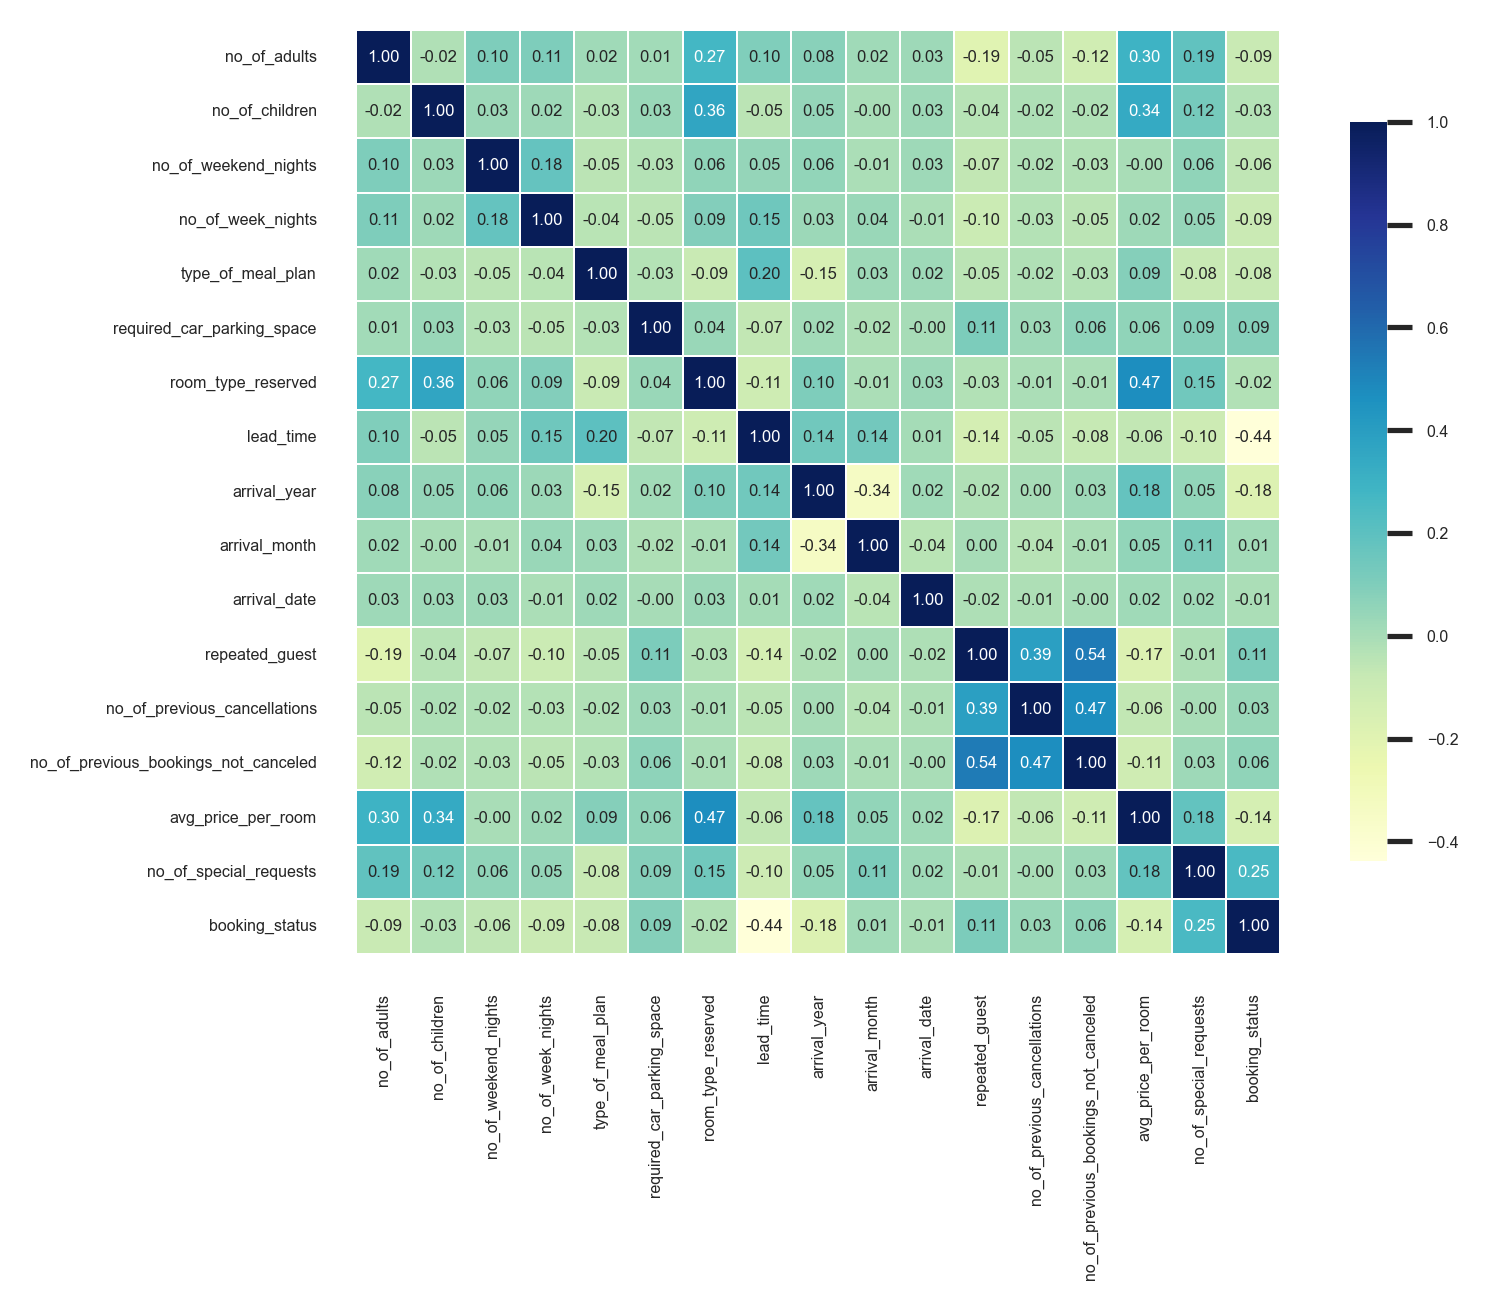

In [122]:
sns.set(font_scale=0.35)
sns.heatmap(df.drop(columns=['Booking_ID', 'market_segment_type']).corr(), cmap='YlGnBu', annot=True, linewidths=0.1, fmt='.2f', square=True, annot_kws={"size": 4}, cbar_kws={"shrink": 0.8})

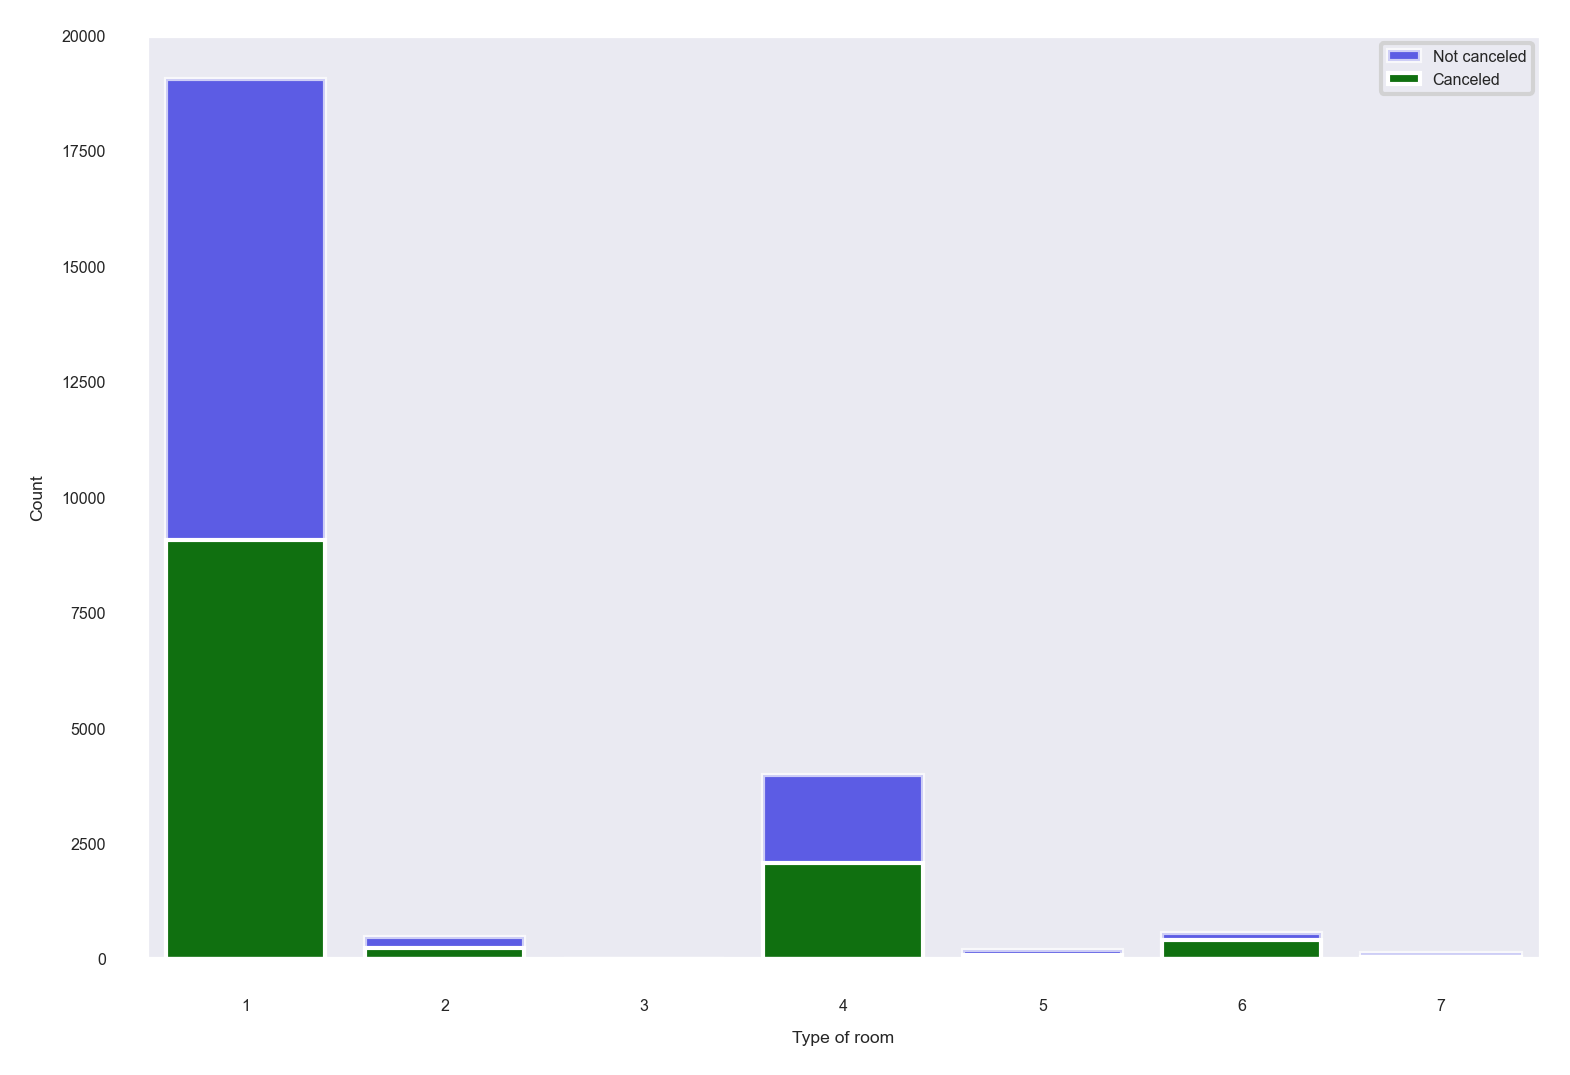

In [123]:
sns.set_style('dark')
pivot_table0 = pd.pivot_table(data=df[df['booking_status']==1], values='booking_status', index='room_type_reserved', aggfunc='count')
pivot_table1 = pd.pivot_table(data=df[df['booking_status']==0], values='booking_status', index='room_type_reserved', aggfunc='count')
pivot_table0.reset_index()
pivot_table1.reset_index()
sns.barplot(data=pivot_table0, x='room_type_reserved', y='booking_status', label='Not canceled', color='blue', alpha=0.7)
sns.barplot(data=pivot_table1, x='room_type_reserved', y='booking_status', label='Canceled', color='green')
plt.xlabel('Type of room')
plt.ylabel('Count')
plt.show()

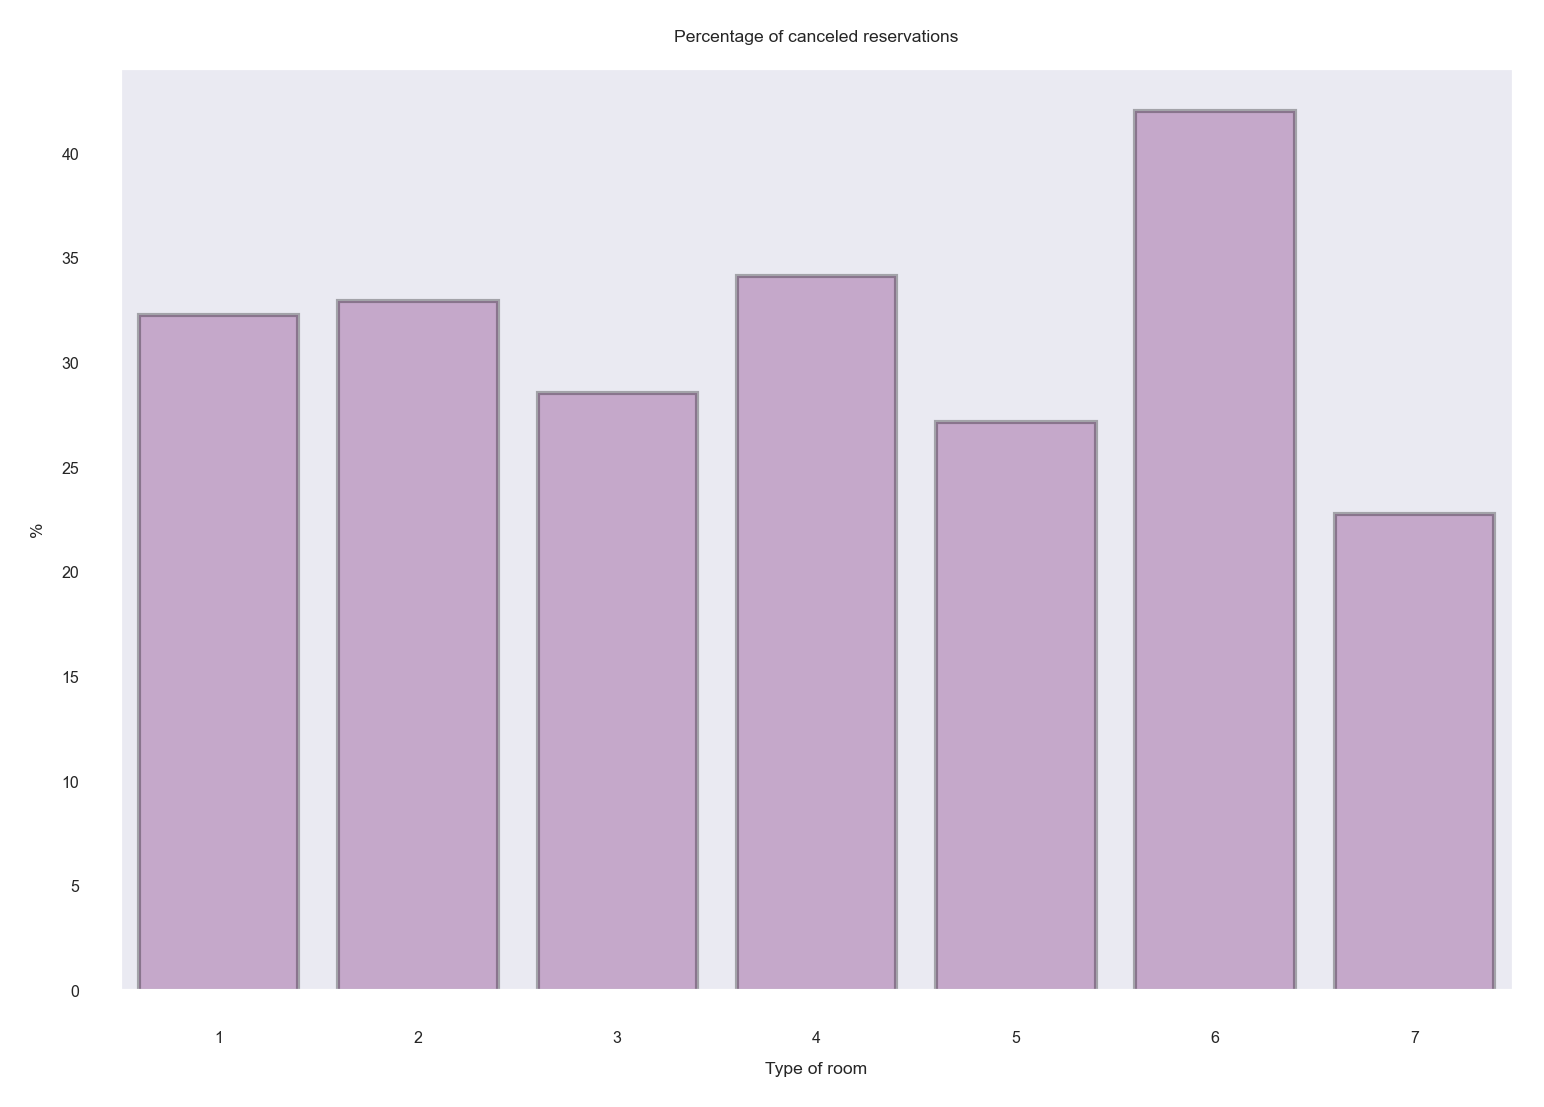

In [124]:
sns.set_style('dark')
merged = pd.merge(pivot_table0, pivot_table1, on='room_type_reserved', suffixes=['_not_canceled', '_canceled'], how='outer')
merged['percentage'] = (merged['booking_status_canceled']/(merged['booking_status_canceled']+merged['booking_status_not_canceled']))*100
sns.barplot(data=merged, x='room_type_reserved', y='percentage', color='purple', alpha=0.3, edgecolor='black')
plt.xlabel('Type of room')
plt.ylabel('%')
plt.title('Percentage of canceled reservations')
plt.show()


As we can see percentage of canceled reservations is similar for most of room types, except for room type 6 which has the biggest cancelation rate, but also one of the smalles amounts of reservations made. 

/var/folders/f1/jg_j0x4x2dsc80qv20x17hgm0000gn/T/ipykernel_39170/1038634428.py:14: RuntimeWarning: invalid value encountered in scalar divide
  vals.append(cp[cp['booking_status']==0].count().iloc[0]/len(cp)*100)


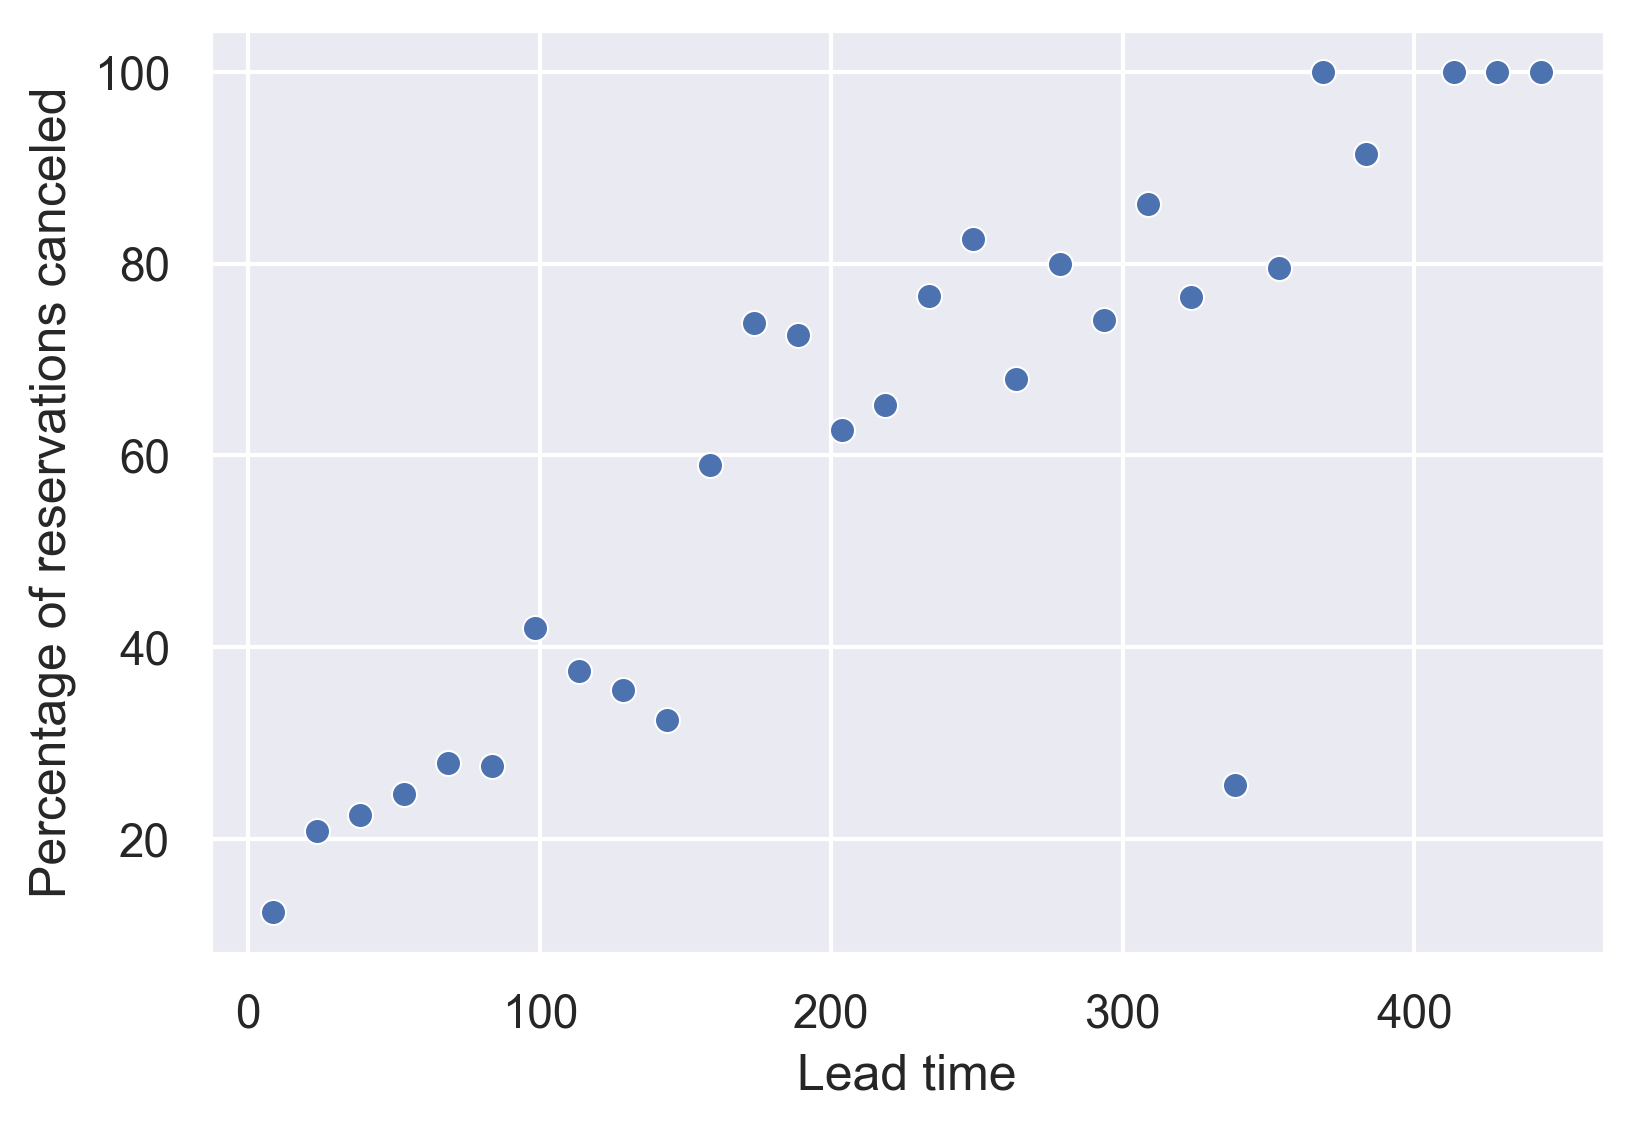

In [125]:
# lead time vs booking status percentage
sns.set_style('dark')
dfc = df[['lead_time', 'booking_status']].copy()
#max lead_time <450
ranges = []
midpoint = []
vals = []
for i in range(1, 451, 15):
    ranges.append((i, i+15))
    midpoint.append((i*2+15)/2)

for r in ranges:
    cp = dfc[(dfc['lead_time']<r[1]) & (dfc['lead_time']>=r[0])]
    vals.append(cp[cp['booking_status']==0].count().iloc[0]/len(cp)*100)
sns.set()
sns.scatterplot(x=midpoint, y=vals)
plt.xlabel('Lead time')
plt.ylabel('Percentage of reservations canceled')
plt.show()


Percentage of canceled is much higher for reservations made with bigger lead time. 

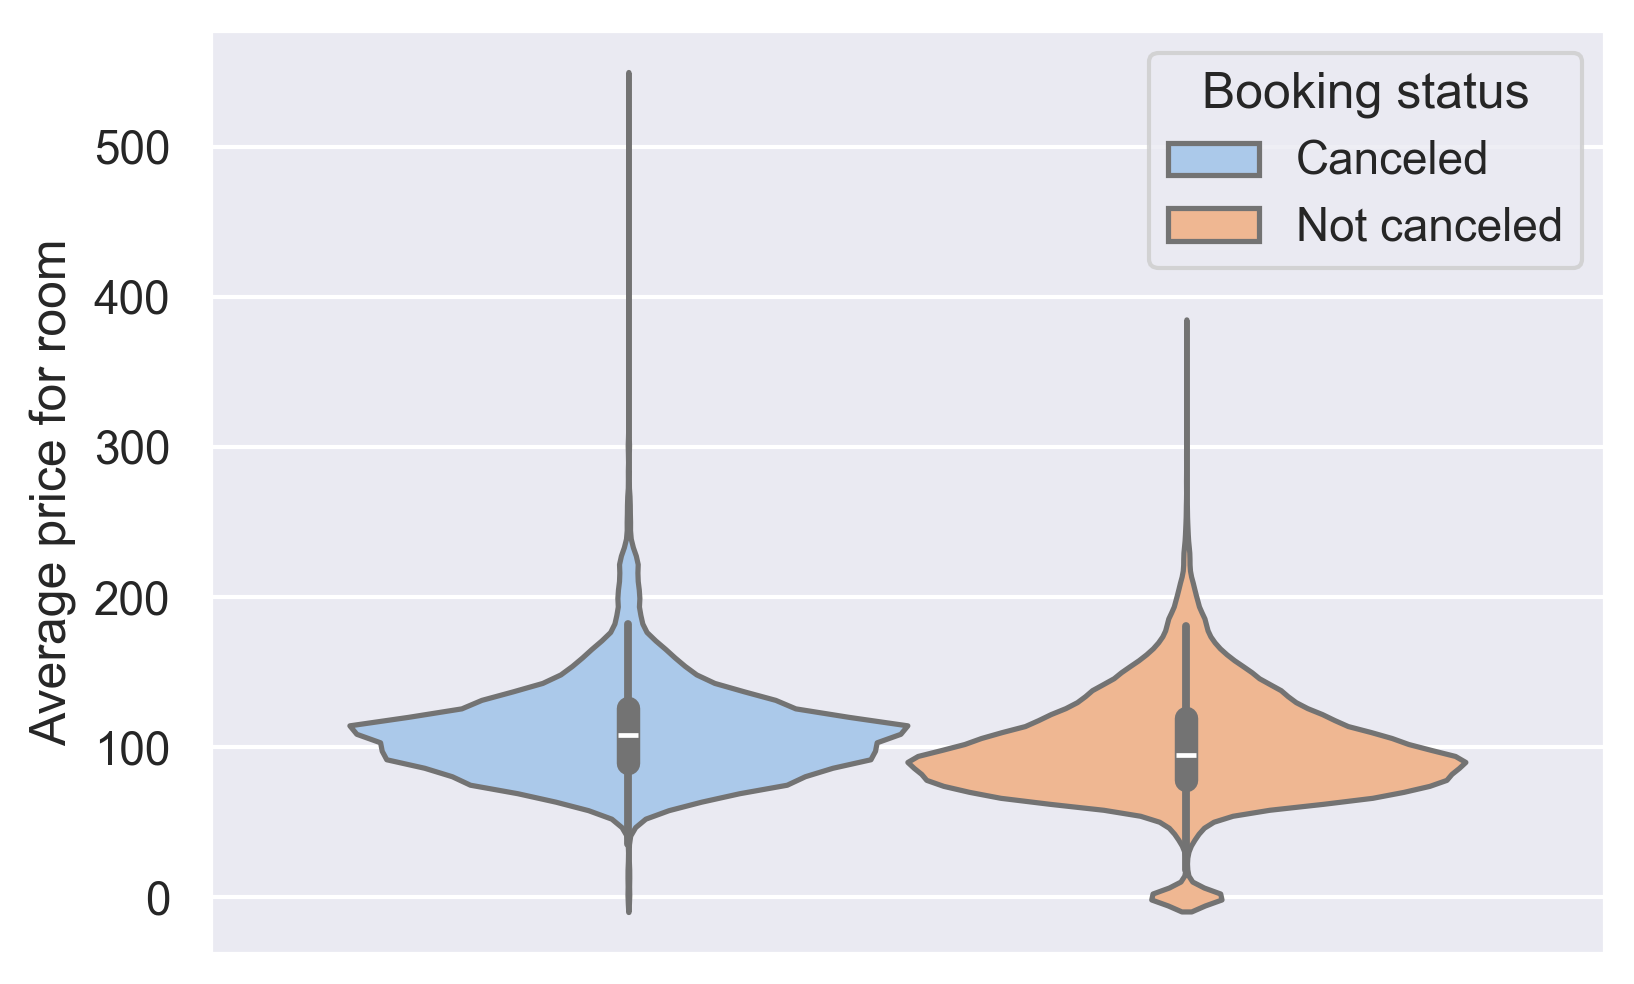

In [126]:
sns.set()
ax = sns.violinplot(data=df, hue='booking_status', y='avg_price_per_room', palette='pastel', legend=True)
handles, labels = ax.get_legend_handles_labels()
ax.legend(handles, ['Canceled', 'Not canceled'], title='Booking status', loc='upper right')
plt.ylabel('Average price for room')
plt.show()

Reservations that have bigger average price per room are canceled more often. \
Now let's check the distribution of our data.

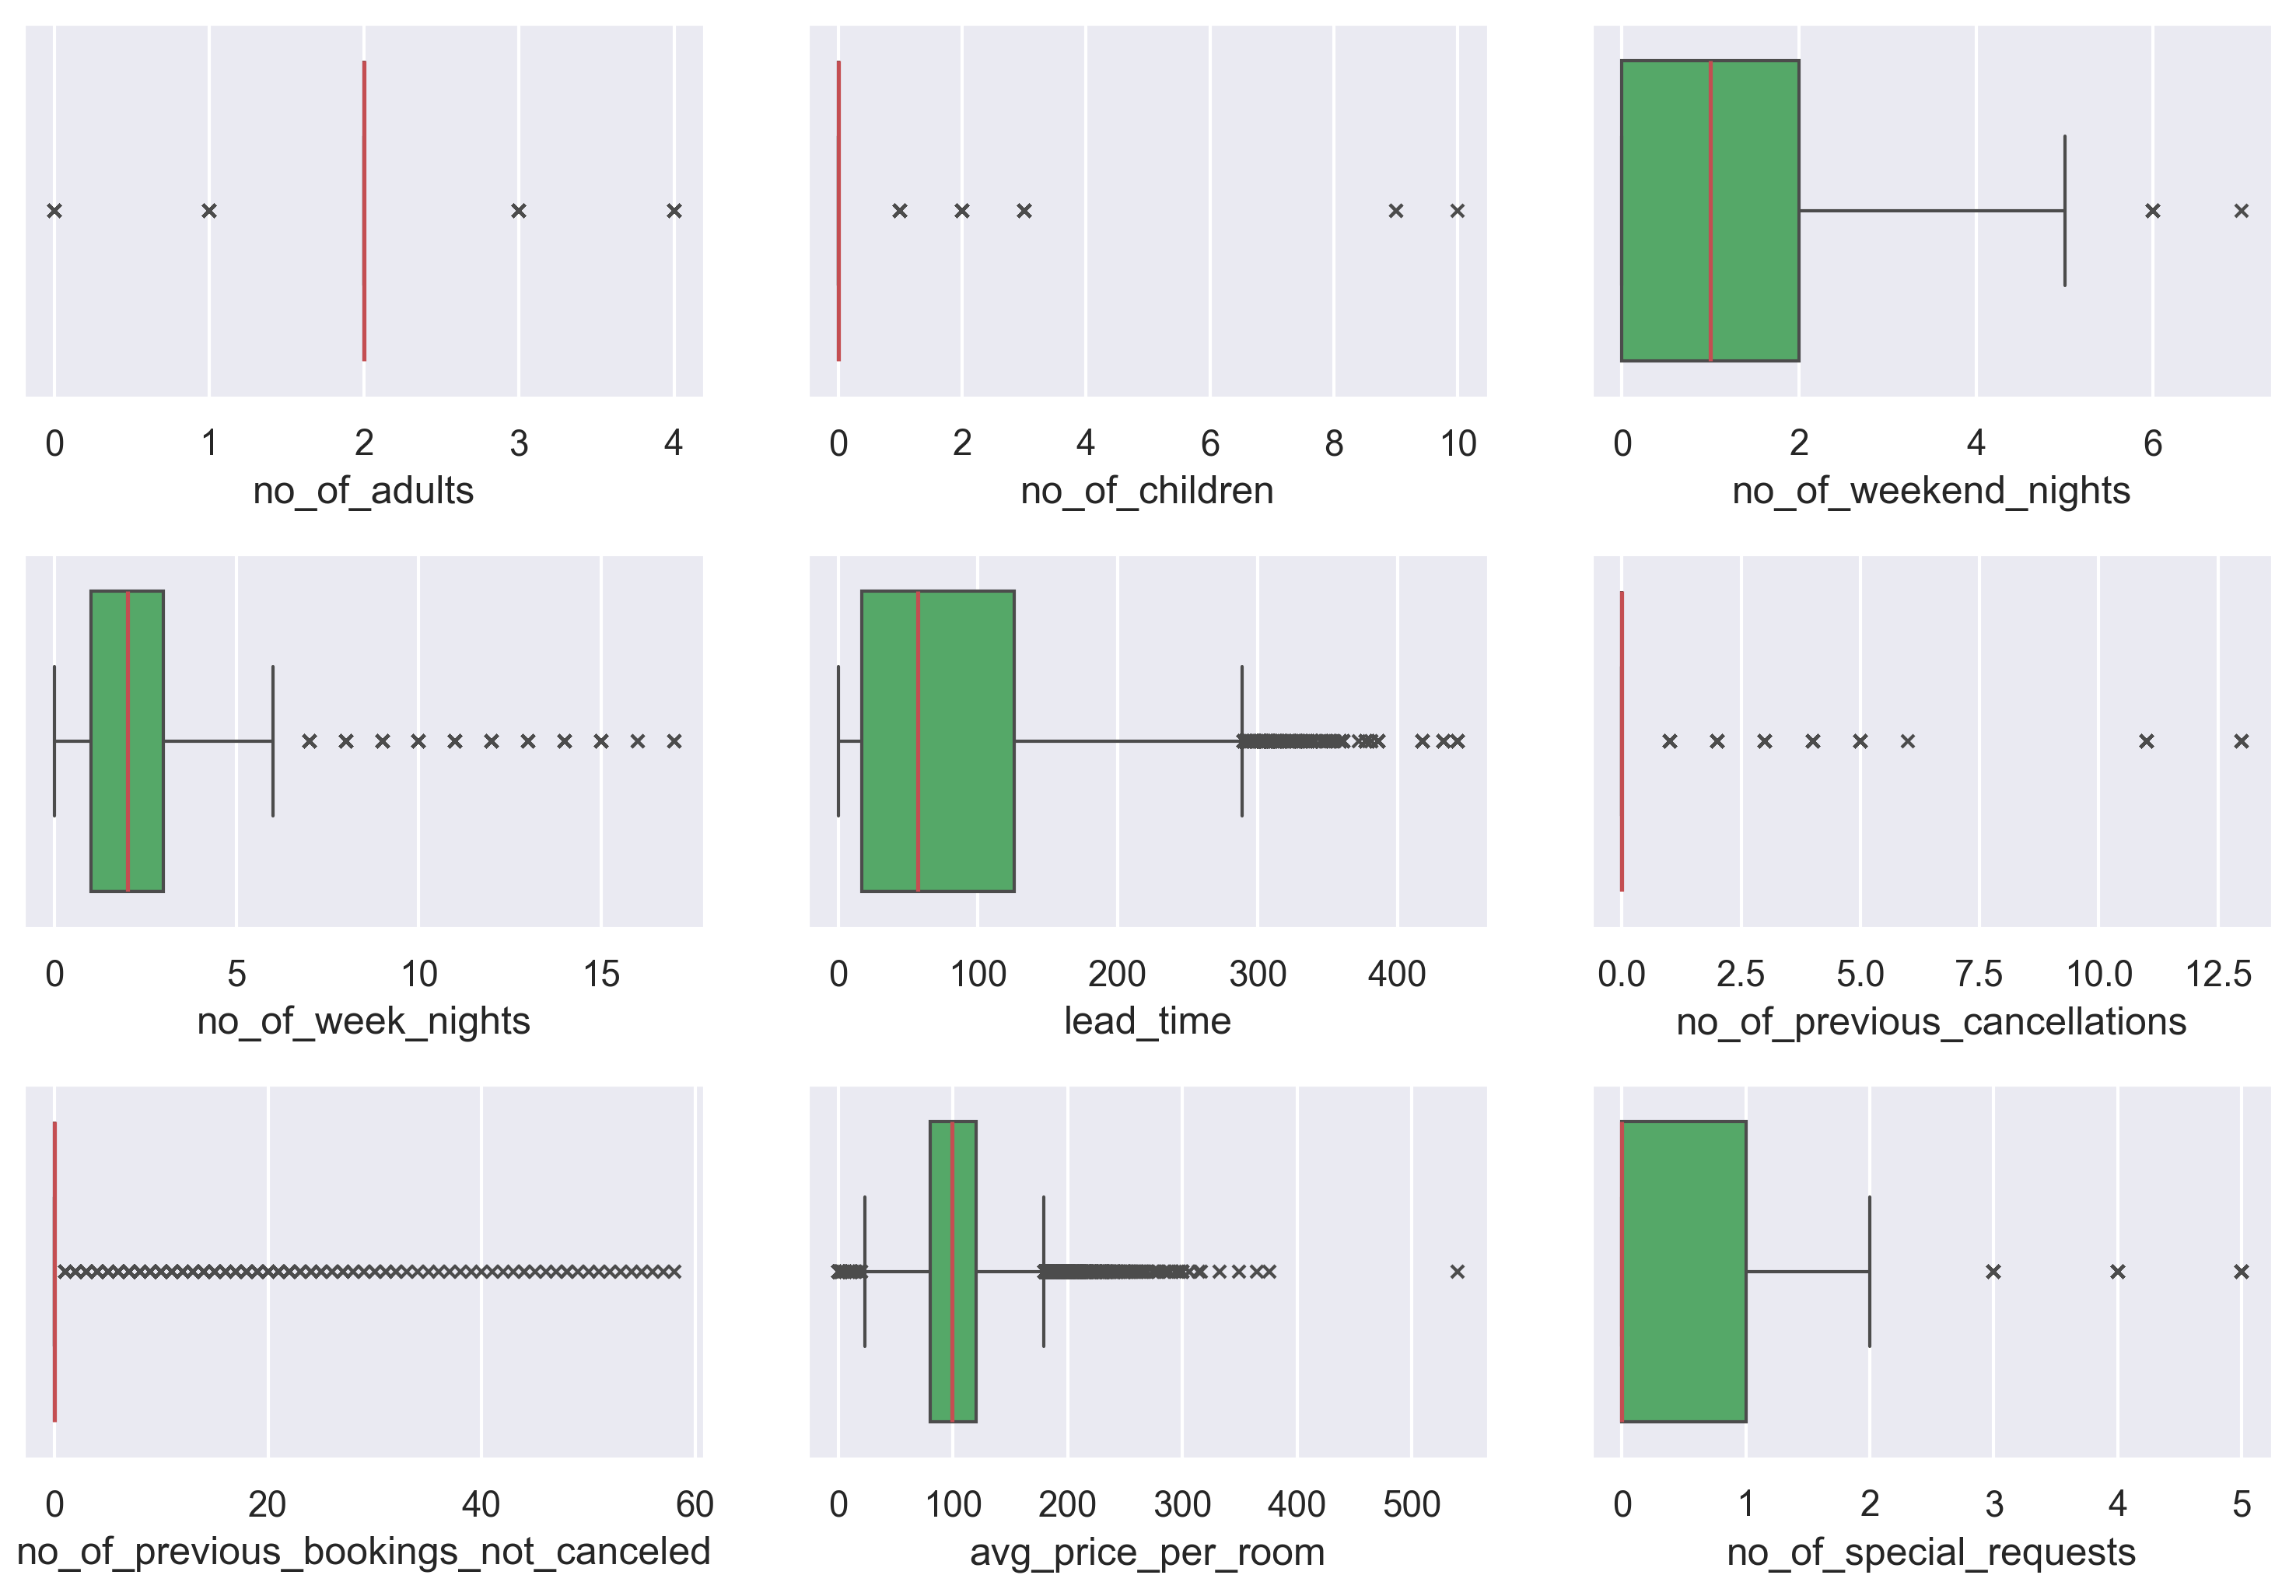

In [127]:
sns.set()
to_plot = ['no_of_adults', 'no_of_children', 'no_of_weekend_nights', 'no_of_week_nights', 'lead_time', 'no_of_previous_cancellations', 'no_of_previous_bookings_not_canceled', 'avg_price_per_room', 'no_of_special_requests']
fig, axes = plt.subplots(nrows=3, ncols=3, figsize=(10, 7))

for i in range(3):
    for j in range(3):
        idx = i*3+j
        sns.boxplot(data=df, x=to_plot[idx], ax=axes[i, j], medianprops={'color':'r', 'linewidth': 1.25}, boxprops={'facecolor': 'g'}, fliersize=4, flierprops={'marker':'x'})
plt.tight_layout()
plt.subplots_adjust(wspace=0.15)
plt.show()
# tried to move titles above each plot, no idea how to do it
# also tried moving the x-axis of each barplot(the values 0,2,4...) higher up but couldnt do that aswell



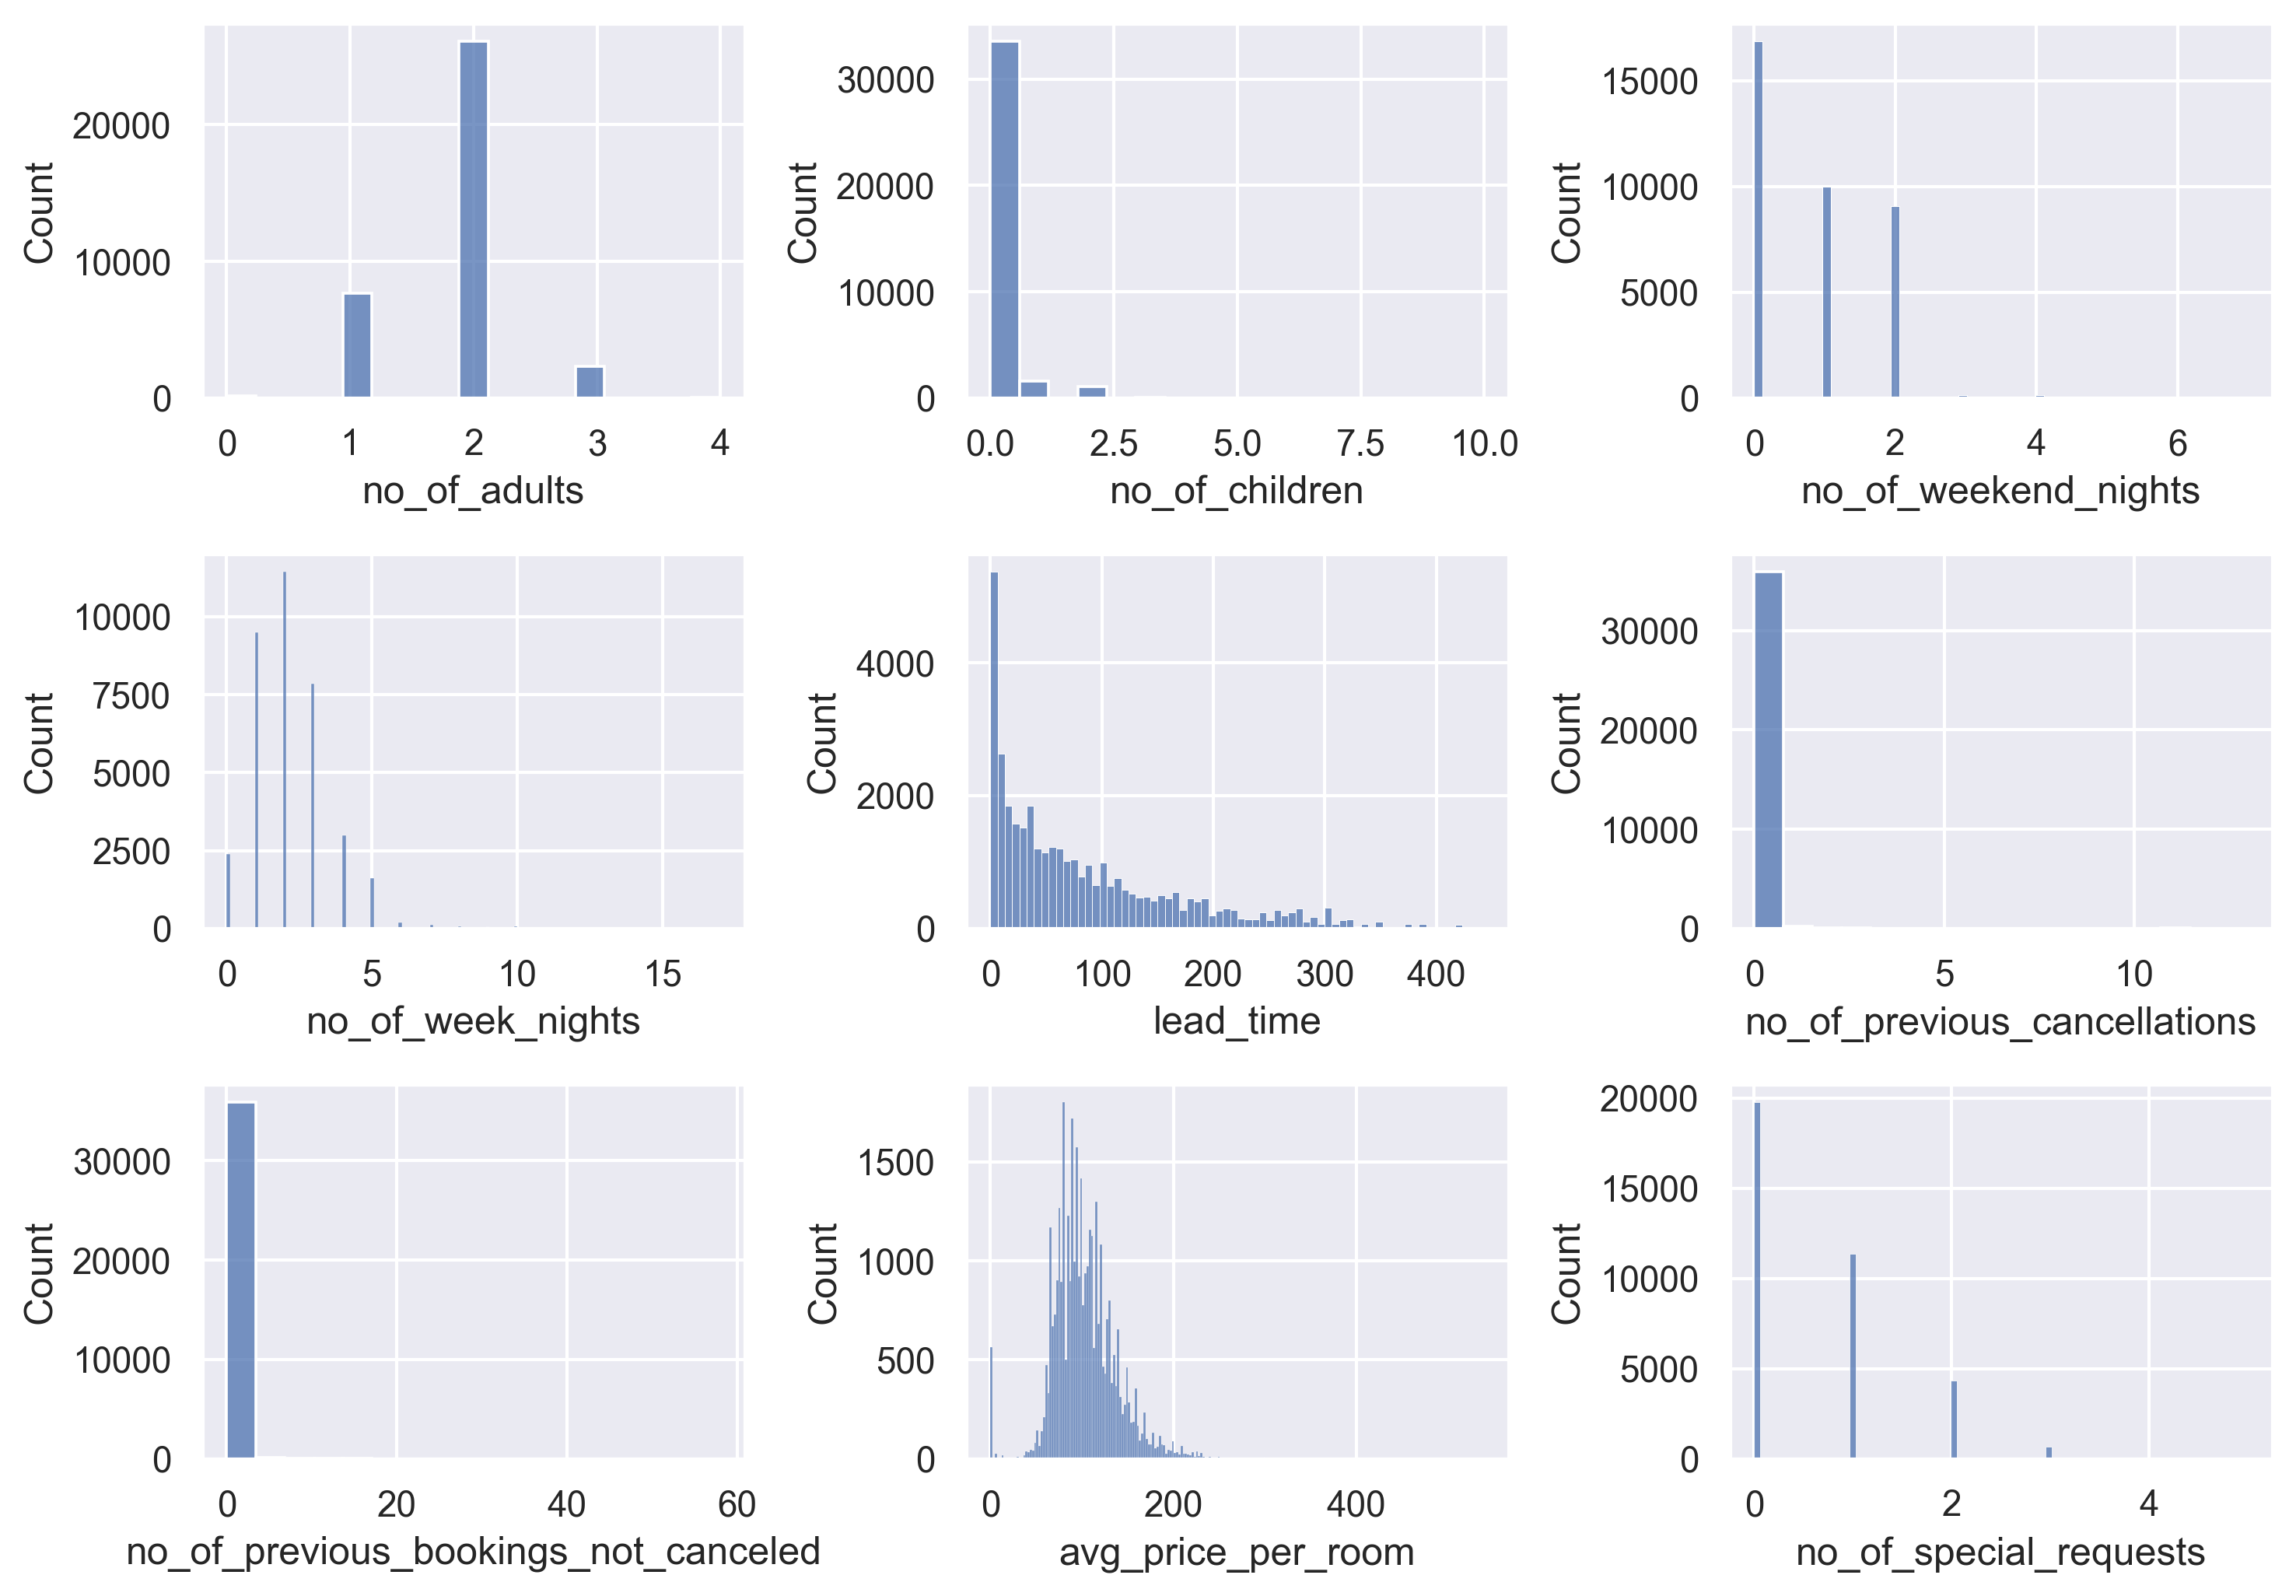

In [129]:
fig, axes = plt.subplots(nrows=3, ncols=3, figsize=(10, 7))
for i in range(3):
    for j in range(3):
        idx = i*3+j
        sns.histplot(data=df, x=to_plot[idx], ax=axes[i, j])
plt.tight_layout()
plt.show()